## IS 590 PR - Final Project 
### Analyzing Olympic Data Set from 1896 to 2016


In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import metrics
import pandas as pd
import dask.dataframe as ddf
import dask.multiprocessing
import warnings
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from pygeodesy.ellipsoidalVincenty import LatLon
from pygeodesy.utily import m2km
from numba import jit
from Latest_Submission import *




warnings.filterwarnings('ignore')



/Users/rj/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Reading the Datasets (By Multiprocessing via Dask Dataframes ) -

In [2]:
world_gdp = read_data_df('Data/world_gdp.csv', skiprows = 3)
noc_country = read_data_df('Data/noc_regions.csv')
world_population = read_data_df('Data/world_pop.csv')
olympics = read_data_df('Data/athlete_events.csv') 
olympics_host = read_data_df('Data/olm2.csv')
world_hdi = read_data_df('Data/hdi.csv')




### Shape of the Dataframes
##### get_shape() function returns the rows and columns of Each Dataset 

In [3]:
print(get_shape(olympics))
print(get_shape(world_gdp))
print(get_shape(noc_country))
print(get_shape(world_population))
print(get_shape(olympics_host))
print(get_shape(world_hdi))

(271116, 15)
(219, 61)
(230, 3)
(217, 61)
(51, 7)
(270, 10)


### Assigning Names to the Dataframe

In [4]:
olympics.name = "Olympics"
world_gdp.name = "World GDP"
noc_country.name = "Country Codes"
world_population.name = "World Population"
olympics_host.name = "Olympics Host Countries"
world_hdi.name = "World HDI data"

### Description of the Dataframes

In [5]:
get_info(olympics)
get_info(world_gdp)
get_info(noc_country)
get_info(world_population)
get_info(olympics_host)
get_info(world_hdi)


The Dataframe "Olympics" has 271116 rows and 15 columns
Column Names - 'ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games', 'Year', 'Season', 'City', 'Sport', 'Event', 'Medal' 


The Dataframe "World GDP" has 219 rows and 61 columns
Column Names - 'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016' 


The Dataframe "Country Codes" has 230 rows and 3 columns
Column Names - 'NOC', 'region', 'notes' 


The Dataframe "World Population" has 217 rows and 61 columns
Column Names - 'Country', 'Country Code', 'In

## Data Cleaning
### Missing Values

In [6]:
get_missing_values(olympics)

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

In [7]:
olympics['Medal'].fillna('No_Medal', inplace=True)

### Validating Datatypes

In [8]:
print(" \n \n{} Dataframe \n \n {} ".format(olympics.name,olympics.dtypes))
print(" \n \n{} Dataframe \n \n {} ".format(world_gdp.name,world_gdp.dtypes))
print(" \n \n{} Dataframe \n \n {} ".format(noc_country.name,noc_country.dtypes))
print(" \n \n{} Dataframe \n \n {} ".format(olympics_host.name,olympics_host.dtypes))
print(" \n \n{} Dataframe \n \n {} ".format(world_hdi.name,world_hdi.dtypes))
print(" {} Dataframe \n \n {} ".format(world_population.name,world_population.dtypes))
world_population[['1998','2000','2016']] = world_population[['1998','2000','2016']].astype(float)

 
 
Olympics Dataframe 
 
 ID          int64
Name       object
Sex        object
Age       float64
Height    float64
Weight    float64
Team       object
NOC        object
Games      object
Year        int64
Season     object
City       object
Sport      object
Event      object
Medal      object
dtype: object 
 
 
World GDP Dataframe 
 
 Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2012              float64
2013              float64
2014              float64
2015              float64
2016              float64
Length: 61, dtype: object 
 
 
Country Codes Dataframe 
 
 NOC       object
region    object
notes     object
dtype: object 
 
 
Olympics Host Countries Dataframe 
 
 Host City             object
Country               object
Summer (Olympiad)     object
Winter                object
Year                   int64
latitude             float64
longitude            float64
dtyp

### One Hot Encoding of Medals Column

#### Reference -  https://www.datacamp.com/community/tutorials/categorical-data


In [9]:
olympics["Bronze_Medal"] = np.where(olympics["Medal"].str.contains("Bronze"), 1, 0)
olympics["Silver_Medal"] = np.where(olympics["Medal"].str.contains("Silver"), 1, 0)
olympics["Gold_Medal"]   = np.where(olympics["Medal"].str.contains("Gold"), 1, 0)
olympics["No_Medal"]     = np.where(olympics["Medal"].str.contains("No_Medal"), 1, 0)

In [10]:
world = world_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1)


### Merging Olympic Athletes Data with NOC

In [11]:
olympics_NOC = olympics.merge(noc_country, left_on='NOC' , right_on='NOC' , how ='left' )

### Cleaning Olympics Host data + Extracting years from it

In [12]:
olympics_host['Year'].fillna(-999, inplace=True)
olympics_host['Winter'].fillna("No_Olympics", inplace=True)
olympics_host['Summer (Olympiad)'].fillna("No_Olympics", inplace=True)
olympic_years = list(olympics_host["Year"].unique())
olympic_years = [str(int(element)) for element in olympic_years]



#### Merging World Population Data with Olympic Athletes (after filtering out the years where olympics wasn't held)

In [13]:
@jit
def filter_years(dataframe, years, olympic_years):
    for item in world_population_columns:
        if item not in olympic_years:
            dataframe.drop(item, axis=1, inplace=True)

In [14]:
world_population_columns = list(world_population.columns.values)[4:]

filter_years(world_population,world_population_columns ,olympic_years )
olympics_NOC_population = olympics_NOC.merge(world_population, left_on='NOC' , right_on='Country Code' , how ='left' ).reset_index(drop=True)


#### Merging World GDP Data with Olympic Athletes (after filtering out the years where olympics wasn't held)


In [15]:

world_gdp_columns = list(world_gdp.columns.values)[4:]

filter_years(world_gdp,world_gdp_columns,olympic_years )

olympics_NOC_gdp = olympics_NOC.merge(world_population, left_on='NOC' , right_on='Country Code' , how ='left' ).reset_index(drop=True)


### American Athletes vs World  - Medals Tally in Olympics . 

In [16]:

american_olympians = olympics_NOC.loc[(olympics_NOC.NOC=='USA') & (olympics_NOC.Medal=='Gold') & (olympics_NOC.Season=='Summer')]
american_olympians

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,City,Sport,Event,Medal,Bronze_Medal,Silver_Medal,Gold_Medal,No_Medal,region,notes
283,150,Margaret Ives Abbott (-Dunne),F,23.0,NaN,NaN,United States,USA,1900 Summer,1900,...,Paris,Golf,Golf Women's Individual,Gold,0,0,1,0,USA,NaN
609,351,Julius Shareef Abdur-Rahim,M,23.0,202.0,104.0,United States,USA,2000 Summer,2000,...,Sydney,Basketball,Basketball Men's Basketball,Gold,0,0,1,0,USA,NaN
710,404,"Louis Grenville ""Lou"" Abell",M,15.0,NaN,NaN,Vesper Boat Club,USA,1900 Summer,1900,...,Paris,Rowing,Rowing Men's Coxed Eights,Gold,0,0,1,0,USA,NaN
711,404,"Louis Grenville ""Lou"" Abell",M,19.0,NaN,NaN,Vesper Boat Club,USA,1904 Summer,1904,...,St. Louis,Rowing,Rowing Men's Coxed Eights,Gold,0,0,1,0,USA,NaN
739,423,Michael Brent Abernathy,M,22.0,182.0,84.0,United States,USA,2000 Summer,2000,...,Sydney,Baseball,Baseball Men's Baseball,Gold,0,0,1,0,USA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266319,133237,"Timothy R. ""Tim"" Young",M,26.0,172.0,77.0,United States,USA,2000 Summer,2000,...,Sydney,Baseball,Baseball Men's Baseball,Gold,0,0,1,0,USA,NaN
267204,133685,Mariel Leigh Zagunis,F,19.0,173.0,72.0,United States,USA,2004 Summer,2004,...,Athina,Fencing,"Fencing Women's Sabre, Individual",Gold,0,0,1,0,USA,NaN
267205,133685,Mariel Leigh Zagunis,F,23.0,173.0,72.0,United States,USA,2008 Summer,2008,...,Beijing,Fencing,"Fencing Women's Sabre, Individual",Gold,0,0,1,0,USA,NaN
269922,135045,Rbert Zimonyi,M,46.0,170.0,52.0,United States,USA,1964 Summer,1964,...,Tokyo,Rowing,Rowing Men's Coxed Eights,Gold,0,0,1,0,USA,NaN


#### We can see that the Gold medals won by America is 1127 (according to Wikipedia) , but the number os rows returned is 2472 . This is due to medallists in team events being counted as individual medallists. Eg : - Soccer has 11 players , It will be counted as 11 medals instead of 1 .

#### Let's Find out Team Events

In [17]:
gold_medals = olympics_NOC[olympics_NOC.Gold_Medal==1]
gold = gold_medals.groupby(['Event','Year'])['ID'].count()
gold
gold_medals['Event_Frequency'] = gold_medals.groupby(['Event','Year'])['ID'].transform('count')
gold = gold_medals[gold_medals.Event_Frequency > 1]
team_events = gold["Event"].unique()
team_events

array(["Tug-Of-War Men's Tug-Of-War", "Gymnastics Men's Team All-Around",
       "Gymnastics Men's Pommelled Horse", "Handball Women's Handball",
       "Speed Skating Men's 1,500 metres", 'Sailing Mixed 8 metres',
       "Cycling Men's Road Race, Team",
       "Canoeing Men's Kayak Fours, 1,000 metres",
       "Handball Men's Handball", "Football Men's Football",
       "Water Polo Men's Water Polo",
       'Sailing Mixed Two Person Heavyweight Dinghy',
       "Rowing Men's Quadruple Sculls", "Rowing Men's Double Sculls",
       "Rowing Men's Coxed Pairs", "Hockey Men's Hockey",
       "Basketball Men's Basketball", "Nordic Combined Men's Team",
       "Ice Hockey Men's Ice Hockey", "Rowing Men's Coxed Eights",
       "Baseball Men's Baseball", "Athletics Men's 4 x 400 metres Relay",
       "Gymnastics Men's Team All-Around, Free System",
       "Gymnastics Men's Team All-Around, Swedish System",
       "Bobsleigh Men's Two", "Curling Men's Curling",
       "Cycling Men's Team Pursuit

### Medals Tally of USA -

In [18]:
tally = olympics_NOC[(olympics_NOC.No_Medal != 1) & (olympics_NOC.Season == "Summer")]
medal_tally = tally[[ 'NOC','Year', 'Sport', 'Event', 'Medal','Bronze_Medal','Silver_Medal', 'Gold_Medal']]

medal_tally_1 = medal_tally.drop_duplicates(['Medal','Event','Year'])

### Gold Medallists of USA - 


In [19]:
medal_tally_1[(medal_tally_1['Medal']=='Gold') & (medal_tally_1['NOC']=='USA')]

,NOC,Year,Sport,Event,Medal,Bronze_Medal,Silver_Medal,Gold_Medal
283,USA,1900,Golf,Golf Women's Individual,Gold,0,0,1
609,USA,2000,Basketball,Basketball Men's Basketball,Gold,0,0,1
710,USA,1900,Rowing,Rowing Men's Coxed Eights,Gold,0,0,1
711,USA,1904,Rowing,Rowing Men's Coxed Eights,Gold,0,0,1
739,USA,2000,Baseball,Baseball Men's Baseball,Gold,0,0,1
...,...,...,...,...,...,...,...,...
266222,USA,1952,Athletics,Athletics Men's Javelin Throw,Gold,0,0,1
266270,USA,1992,Athletics,Athletics Men's 400 metres Hurdles,Gold,0,0,1
266293,USA,1932,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",Gold,0,0,1
267204,USA,2004,Fencing,"Fencing Women's Sabre, Individual",Gold,0,0,1


### Silver Medallists of USA - 

In [20]:
medal_tally_1[(medal_tally_1['Medal']=='Silver') & (medal_tally_1['NOC']=='USA')]

,NOC,Year,Sport,Event,Medal,Bronze_Medal,Silver_Medal,Gold_Medal
186,USA,2004,Wrestling,"Wrestling Men's Featherweight, Freestyle",Silver,0,1,0
286,USA,2008,Softball,Softball Women's Softball,Silver,0,1,0
311,USA,2004,Taekwondo,Taekwondo Women's Featherweight,Silver,0,1,0
1450,USA,1912,Athletics,Athletics Men's Standing High Jump,Silver,0,1,0
1462,USA,1904,Swimming,Swimming Men's Plunge For Distance,Silver,0,1,0
...,...,...,...,...,...,...,...,...
262882,USA,1972,Athletics,Athletics Men's Shot Put,Silver,0,1,0
263273,USA,1968,Shooting,"Shooting Mixed Small-Bore Rifle, Three Positio...",Silver,0,1,0
263511,USA,2000,Archery,Archery Men's Individual,Silver,0,1,0
263619,USA,1924,Swimming,Swimming Men's 100 metres Backstroke,Silver,0,1,0


### Bronze Medal Tally of USA - 

In [21]:
medal_tally_1[(medal_tally_1['Medal']=='Bronze') & (medal_tally_1['NOC']=='USA')]

,NOC,Year,Sport,Event,Medal,Bronze_Medal,Silver_Medal,Gold_Medal
1451,USA,1912,Athletics,Athletics Men's Standing Long Jump,Bronze,1,0,0
1514,USA,2016,Volleyball,Volleyball Women's Volleyball,Bronze,1,0,0
1847,USA,2016,Swimming,Swimming Men's 50 metres Freestyle,Bronze,1,0,0
1848,USA,2016,Swimming,Swimming Men's 100 metres Freestyle,Bronze,1,0,0
3095,USA,2016,Fencing,"Fencing Women's Sabre, Team",Bronze,1,0,0
...,...,...,...,...,...,...,...,...
266273,USA,1968,Athletics,Athletics Men's 50 kilometres Walk,Bronze,1,0,0
266275,USA,1972,Athletics,Athletics Men's 50 kilometres Walk,Bronze,1,0,0
266329,USA,1968,Diving,Diving Men's Platform,Bronze,1,0,0
267868,USA,1932,Athletics,Athletics Men's Hammer Throw,Bronze,1,0,0


### Visualising Overall Tally with individual Medals (Gold, Silver, Bronze)

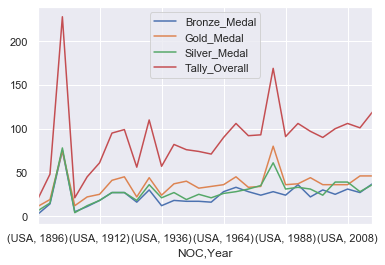

In [22]:
medal_tally_1['Tally_Overall'] = medal_tally_1['Bronze_Medal'].astype(int)+medal_tally_1['Silver_Medal'].astype(int)+medal_tally_1['Gold_Medal'].astype(int)
sns.set()
medal_tally_usa = medal_tally_1[medal_tally_1['NOC']=='USA']
medal_tally_usa=pd.pivot_table(medal_tally_usa, index=['NOC','Year'],values=['Bronze_Medal','Silver_Medal','Gold_Medal','Tally_Overall'],aggfunc=np.sum)
medal_tally_usa.plot()




### USA's Medal Tally by Year (sorted by Medal Tally )

In [23]:
medal_tally_usa.sort_values('Tally_Overall',ascending=False)


Bronze_Medal  Gold_Medal  Silver_Medal  Tally_Overall
NOC Year                                                       
USA 1904            75          75            78            228
    1984            28          80            61            169
    2016            37          46            36            119
    1932            30          44            36            110
    2008            31          36            39            106
    1968            33          45            28            106
    1992            36          37            33            106
    2012            27          46            28            101
    2004            25          36            39            100
    1924            27          45            27             99
    1996            22          44            31             97
    1920            27          41            27             95
    1976            24          34            35             93
    1972            28          33            31             92
    1988            24          36            31             91
    2000            30          36            24             90
    1964            28          36            26             90
    1948            18          37            27             82
    1952            17          40            19             76
    1956            17          32            25             74
    1960            16          34            21             71
    1912            18          25            18             61
    1936            12          24            21             57
    1928            16          22            18             56
    1900            14          19            15             48
    1908            11          22            12             45
    1906             5          12             4             21
    1896             2          11             6             19


### Medal Tally of All Countries By Year (Sorted by Overall Tally)


In [24]:
medal_tally_by_year=pd.pivot_table(medal_tally_1, index=['NOC','Year'],values=['Bronze_Medal','Silver_Medal','Gold_Medal','Tally_Overall'],aggfunc=np.sum)

medal_tally_by_year.sort_values('Tally_Overall',ascending=False)

Bronze_Medal  Gold_Medal  Silver_Medal  Tally_Overall
NOC Year                                                       
USA 1904            75          75            78            228
URS 1980            43          79            68            190
USA 1984            28          80            61            169
GBR 1908            36          56            49            141
URS 1988            41          53            31            125
...                ...         ...           ...            ...
POR 1936             1           0             0              1
    1928             1           0             0              1
    1924             1           0             0              1
GAB 2012             0           0             1              1
AHO 1988             0           0             1              1

[1243 rows x 4 columns]

### Medal Tally of All Countries  from 1896 - 2016 (Sorted by Overall Tally)

In [25]:
medal_tally_overall=pd.pivot_table(medal_tally_1, index=['NOC'],values=['Bronze_Medal','Silver_Medal','Gold_Medal','Tally_Overall'],aggfunc=np.sum)
medal_tally_overall = medal_tally_overall.sort_values('Tally_Overall',ascending=False)
medal_tally_overall

,Bronze_Medal,Gold_Medal,Silver_Medal,Tally_Overall
NOC,,,,
USA,678,1028,796,2502
URS,270,385,311,966
GBR,276,275,312,863
GER,257,229,259,745
FRA,259,233,248,740
...,...,...,...,...
MKD,1,0,0,1
MNE,0,0,1,1
MON,1,0,0,1


### Pie Chart of Medal Distribution of top 20 Countries

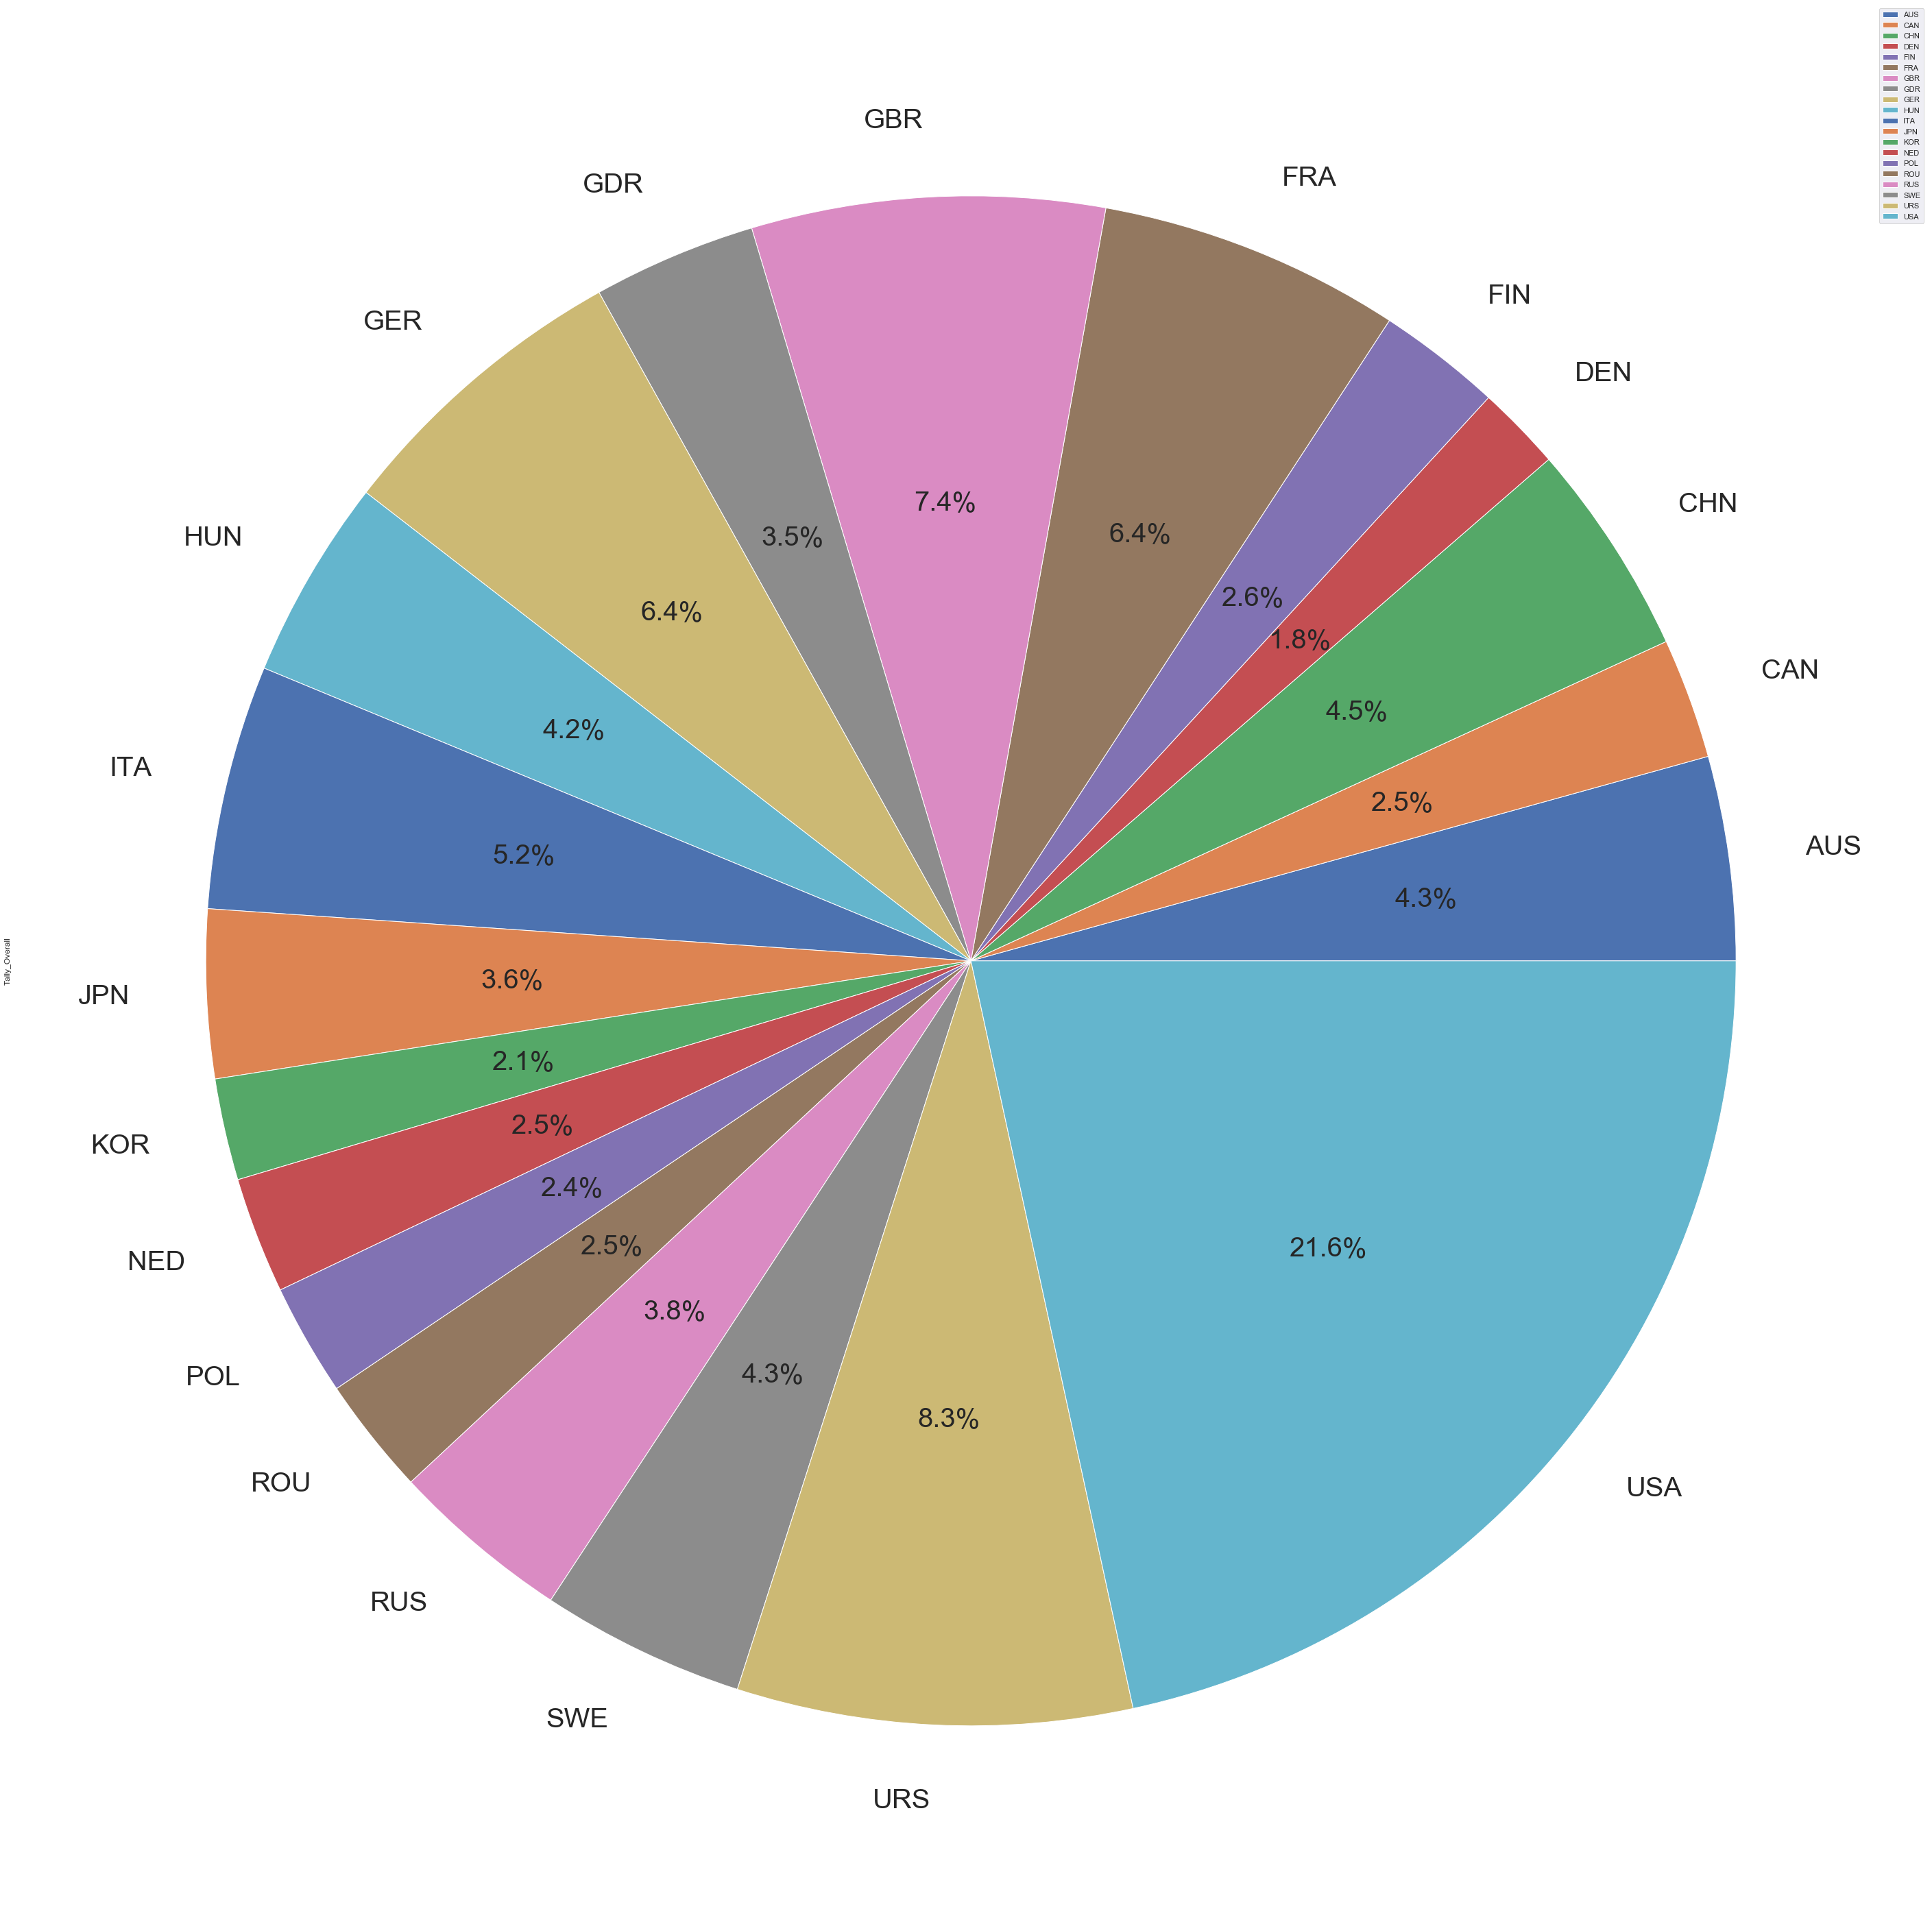

In [26]:
sns.set()

medal_tally_overall=pd.pivot_table(medal_tally_overall.head(20), index=['NOC'],values=['Tally_Overall'],aggfunc=np.sum).plot(kind='pie',subplots=True,figsize=(50,100),
       autopct='%1.1f%%',textprops={'fontsize': 40})

### Home Advantage
##### Countries actively place lucrative bids to get the hosting rights of every Olympics edition . Apart from Socio-political and economic reasons , we try to explore whether Home advantage impacts a given country's medals tally as well
##### Based on the previous and next olympics' medal tally, we can clearly see the home advantage enjoyed by the host country in the below table.

##### Inspired from - https://www.kaggle.com/chadalee/olympics-data-cleaning-exploration-prediction

### Olympics host Countries 

In [27]:
olympic_host_noc= olympics_host.merge(noc_country, left_on='Country' , right_on=u'region' , how ='left' )

olympic_host_noc = olympic_host_noc.drop_duplicates(['Country','Year','Summer (Olympiad)'])
olympic_host_noc = olympic_host_noc.drop_duplicates(['Country','Year','Winter'])
olympic_host_noc = olympic_host_noc.drop_duplicates(['Country','Year'] , keep='last')
olympic_host_noc = olympic_host_noc[['Year', 'NOC']]
olympic_host_noc.columns = ['Year_of_Hosting', 'Host_Country_code']
olympic_host_noc

,Year_of_Hosting,Host_Country_code
0,1896,CRT
2,1900,FRA
3,1904,USA
4,1908,GBR
5,1912,SWE
6,1920,BEL
8,1924,FRA
9,1928,SUI
10,1928,NED
12,1932,USA


### Medal Tally along with Previous and Next Year Tally
##### Reference - https://stackoverflow.com/questions/34855859/is-there-a-way-in-pandas-to-use-previous-row-value-in-dataframe-apply-when-previ


In [28]:

medal_tally_by_year.reset_index(inplace=True)
medal_tally_by_year = medal_tally_by_year[['NOC', 'Year','Tally_Overall']]
total_medals = medal_tally_by_year[['NOC','Year','Tally_Overall']]




@jit
def previous_year(tally):
    new_tally = np.empty(tally.shape)
    new_tally[0] =0
    for i in range(1, new_tally.shape[0]):
        new_tally[i] = tally[i-1]
    return new_tally

@jit
def next_year(tally):
    new_tally = np.empty(tally.shape)
    new_tally[tally.shape[0]-1] =0
    for i in range(0, new_tally.shape[0]-1):
        new_tally[i] = tally[i+1]
    return new_tally

total_medals['Previous_Year_Tally'] = previous_year(total_medals['Tally_Overall'])
total_medals['Next_Year_Tally'] = next_year(total_medals['Tally_Overall'])

host_country_tally = olympic_host_noc.merge(total_medals , left_on = [ 'Host_Country_code','Year_of_Hosting'] 
                                           , right_on =['NOC', 'Year'] , how = 'left' )


host = host_country_tally.dropna()
host=host[['Year_of_Hosting', 'Host_Country_code','Previous_Year_Tally', 'Tally_Overall', 'Next_Year_Tally']]
host




,Year_of_Hosting,Host_Country_code,Previous_Year_Tally,Tally_Overall,Next_Year_Tally
1,1900,FRA,11.0,95.0,2.0
2,1904,USA,48.0,228.0,21.0
3,1908,GBR,25.0,141.0,41.0
4,1912,SWE,24.0,63.0,63.0
5,1920,BEL,6.0,40.0,13.0
6,1924,FRA,42.0,38.0,25.0
7,1928,SUI,25.0,17.0,1.0
8,1928,NED,11.0,23.0,8.0
9,1932,USA,56.0,110.0,57.0
11,1948,SUI,17.0,22.0,13.0


### Can we Predict the Overall Medal Tally of a given country ?

##### Research Paper - "Standards on age, height and weight in Olympic running events for men" -  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1859632/?page=2 

##### The Research Paper nails down 6 essential factors when it comes to influencing the medal tally of a given country
##### They are as follows - 

[Medal_Tally.png](attachment:Medal_Tally.png)


##### We try to fit a linear regression line having GDP , Population , GDP per Capita and No of athletes of a given country and see how our Predictor Works. 

##### Inspired By - https://www.kaggle.com/chadalee/olympics-data-cleaning-exploration-prediction

In [29]:
predictor = medal_tally_by_year

### Merging GDP Data with Year of Participation of the country

In [30]:
gdp = olympics_NOC_gdp.drop_duplicates(['Country','Year'])
gdp =  gdp.drop(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Games', 'Season', 'City', 'Sport', 'Event', 'Medal', 'Bronze_Medal',
       'Silver_Medal', 'Gold_Medal', 'No_Medal', 'region', 'notes', 'Country',
       'Country Code', 'Indicator Name', 'Indicator Code'],axis=1)
gdp.dropna(inplace=True)
gdp = gdp[gdp.Year>=1960]
pivot_gdp = pd.melt(world, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP') #inspired
pivot_gdp.dropna(inplace=True)

pivot_gdp


,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
2,Algeria,DZA,1960,2.723649e+09
10,Australia,AUS,1960,1.859335e+10
11,Austria,AUT,1960,6.592694e+09
13,Bahamas,BHS,1960,1.698039e+08
...,...,...,...,...
12477,Vietnam,VNM,2016,2.052760e+11
12479,Palestine,PSE,2016,1.339710e+10
12480,Yemen,YEM,2016,2.731761e+10
12481,Zambia,ZMB,2016,2.106399e+10


### Merging Population Data with Year of Participation of the country

In [31]:
pop = world_population.drop(world_population.columns[[2, 3]], axis=1)
pivot_pop = pd.melt(pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population') #inspired
pivot_pop

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0
...,...,...,...,...
4552,Kosovo,XKX,2016,1816200.0
4553,"Yemen, Rep.",YEM,2016,27584213.0
4554,South Africa,ZAF,2016,55908865.0
4555,Zambia,ZMB,2016,16591390.0


### Correlation Matrix of the variables

#### We can see that GDP , Population and Per_Capita_GDP have positive correlation with the medals tally with GDP showing the highest correlation (0.67)

### Merged Frame with Corresponding GDP , Population and GDP Per-capita income with Year of Participation of the country

In [32]:
gdp_pop = pivot_gdp.merge(pivot_pop,left_on =['Country Code' , 'Year'],right_on = ['Country Code' , 'Year'] , how='left' )
gdp_pop.drop_duplicates(['Country Code', 'Year' ])
gdp_pop.dropna(inplace=True)

gdp_pop = gdp_pop[['Country Name' , 'Country Code' , 'Year' , 'GDP' , 'Population']]
gdp_pop
predictor['Year'] = predictor['Year'].astype('str')
pred = gdp_pop.merge(predictor, left_on =['Country Code', 'Year'] , right_on = ['NOC' , 'Year'] , how ='left' )
predictor['Year'] = predictor['Year'].astype('str')
pred.dropna()
pred['Per_Capita_GDP'] = pred['GDP']/pred['Population']
pred.dropna(inplace=True)
pred
#predictor['Population']= g[(predictor['Year']==g['Year']) & (predictor['NOC']== g['NOC'])]['Team']

,Country Name,Country Code,Year,GDP,Population,NOC,Tally_Overall,Per_Capita_GDP
2,Australia,AUS,1960,1.859335e+10,10276477.0,AUS,21.0,1809.311452
3,Austria,AUT,1960,6.592694e+09,7047539.0,AUT,2.0,935.460427
6,Belgium,BEL,1960,1.165872e+10,9153489.0,BEL,4.0,1273.691659
12,Brazil,BRA,1960,1.516557e+10,72207554.0,BRA,2.0,210.027470
17,Canada,CAN,1960,4.109345e+10,17909009.0,CAN,1.0,2294.568814
...,...,...,...,...,...,...,...,...
3581,Turkey,TUR,2016,8.637120e+11,79512426.0,TUR,7.0,10862.604041
3585,Ukraine,UKR,2016,9.327048e+10,45004645.0,UKR,11.0,2072.463395
3587,UK,GBR,2016,2.647900e+12,65637239.0,GBR,65.0,40341.428743
3588,USA,USA,2016,1.862450e+13,323127513.0,USA,119.0,57638.236457


In [33]:
correlation_matrix = pred.corr()
correlation_matrix.style.background_gradient(cmap='seismic')

,GDP,Population,Tally_Overall,Per_Capita_GDP
GDP,1,0.348838,0.674394,0.357441
Population,0.348838,1,0.350107,-0.0958071
Tally_Overall,0.674394,0.350107,1,0.200959
Per_Capita_GDP,0.357441,-0.0958071,0.200959,1


### Normalise and Classify the models 
#### We need to normalise the input data as there is high variance in them
#### We will use MinMax Scaler to Normalise the data


###  Classifer - 
#### We will use linear regression to predict the medal tally of the country


In [34]:
#Classifier 

scaler = preprocessing.MinMaxScaler()
A = pred[['GDP', 'Population' , 'Per_Capita_GDP']]
A = scaler.fit_transform(A)
B = pred['Tally_Overall']

model = sm.OLS(B, A)
results_model = model.fit()
print(results_model.summary())

B_predicted = results_model.predict(A)
rmse = np.sqrt(metrics.mean_squared_error(B, B_predicted))
print("Root Mean Square Error of Linear Regression " +  str(rmse))


                                 OLS Regression Results                                
Dep. Variable:          Tally_Overall   R-squared (uncentered):                   0.559
Model:                            OLS   Adj. R-squared (uncentered):              0.557
Method:                 Least Squares   F-statistic:                              237.2
Date:                Sat, 04 Jan 2020   Prob (F-statistic):                    2.38e-99
Time:                        00:32:05   Log-Likelihood:                         -2354.0
No. Observations:                 564   AIC:                                      4714.
Df Residuals:                     561   BIC:                                      4727.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### We can see that R-Squared Value of linear Regression is 0.59 (59% accuracy) and RMSE is 15.7 which means the predictor is predicting with an error of 15 medals.
#### Can we Improve this preformance ? 

#### Let's try to predict with Random Forest Regression and see it's performance.

### Random Forest Regression

Random Forest Regression : 0.94
Root Mean Square Error Of Random Forest Regressor 4.922218190500459


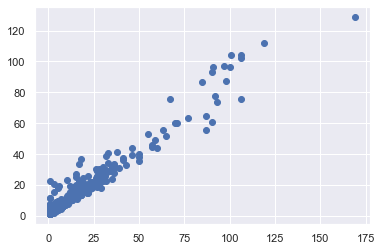

In [35]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(A, B)

print("Random Forest Regression : {:.2f}".format(reg.score(A, B)))
B_predict = reg.predict(A)

rmse = np.sqrt(metrics.mean_squared_error(B, B_predict))
print("Root Mean Square Error Of Random Forest Regressor " + str(rmse) )
plt.scatter(B, B_predict)

#gdp['Population'] = str(list(gdp['Year'].values))

#### We can see that R-Squared Value of Random Forest Regression is 0.94 (94% accuracy) and RMSE is 4.85 which means the predictor is predicting with an error of 5 medals.

#### There is a drastic increase in the accuracy with Random Forest Regression

## HDI  (Human Development Index)

### Let's investigate whether HDI has an impact on Medal Tally. In our dataset , we have HDI Data for 3 Olympics years - 1980 , 2000 and 2008

### Merging HDI data with NOC Data 

In [36]:
world_hdi.dropna(inplace=True)
pivot_hdi = pd.melt(world_hdi, id_vars = ['HDI'], value_name = 'Human_Dev_Index') #inspired
pivot_hdi.dropna(inplace=True)
pivot_hdi_noc = pivot_hdi.merge(noc_country , left_on ='HDI' , right_on='region' , how='left' ) 

pivot_hdi_noc.drop_duplicates(['variable','region','HDI'],keep='last')

pivot_hdi_noc = pivot_hdi_noc[['NOC', 'variable' , 'Human_Dev_Index' ,'HDI' ]]
pivot_hdi_noc.dropna(inplace=True)
pivot_hdi_noc.columns = ['NOC_HDI','Year_HDI', 'Human_Dev_Index' ,'Country_HDI' ]
pivot_hdi_noc

,NOC_HDI,Year_HDI,Human_Dev_Index,Country_HDI
0,AFG,1980,0.198,Afghanistan
1,ALG,1980,0.454,Algeria
2,ARG,1980,0.669,Argentina
3,ANZ,1980,0.850,Australia
4,AUS,1980,0.850,Australia
...,...,...,...,...
1039,URU,2011,0.783,Uruguay
1040,VEN,2011,0.735,Venezuela
1041,ZAM,2011,0.430,Zambia
1042,RHO,2011,0.376,Zimbabwe


In [37]:

pred = pred.merge(pivot_hdi_noc , left_on=['Country Name' ,'Year'] , right_on = ['Country_HDI','Year_HDI'] ,how='left' )
pred.dropna(inplace=True)
pred

,Country Name,Country Code,Year,GDP,Population,NOC,Tally_Overall,Per_Capita_GDP,NOC_HDI,Year_HDI,Human_Dev_Index,Country_HDI
120,Australia,AUS,1980,1.498870e+11,14692000.0,AUS,9.0,10201.946638,ANZ,1980,0.850,Australia
121,Australia,AUS,1980,1.498870e+11,14692000.0,AUS,9.0,10201.946638,AUS,1980,0.850,Australia
122,Austria,AUT,1980,8.205891e+10,7549433.0,AUT,4.0,10869.546424,AUT,1980,0.740,Austria
123,Belgium,BEL,1980,1.275080e+11,9859242.0,BEL,1.0,12932.840070,BEL,1980,0.757,Belgium
124,Brazil,BRA,1980,2.350250e+11,121159761.0,BRA,4.0,1939.794186,BRA,1980,0.549,Brazil
...,...,...,...,...,...,...,...,...,...,...,...,...
449,Sweden,SWE,2008,5.139660e+11,9219637.0,SWE,5.0,55746.880273,SWE,2008,0.900,Sweden
451,Thailand,THA,2008,2.913830e+11,66545760.0,THA,4.0,4378.686185,THA,2008,0.672,Thailand
453,Tunisia,TUN,2008,4.485659e+10,10407336.0,TUN,1.0,4310.093026,TUN,2008,0.688,Tunisia
454,Turkey,TUR,2008,7.643360e+11,70440032.0,TUR,5.0,10850.875252,TUR,2008,0.691,Turkey


#### Correlation Matrix with HDI

In [38]:
correlation_matrix = pred.corr()
correlation_matrix.style.background_gradient(cmap='seismic')

,GDP,Population,Tally_Overall,Per_Capita_GDP,Human_Dev_Index
GDP,1,0.457163,0.642159,0.193817,0.169667
Population,0.457163,1,0.571119,-0.27975,-0.395806
Tally_Overall,0.642159,0.571119,1,0.0403584,0.132623
Per_Capita_GDP,0.193817,-0.27975,0.0403584,1,0.751846
Human_Dev_Index,0.169667,-0.395806,0.132623,0.751846,1


#### Although not significant , HDI does have a positive correlation with the Medal Tally. 
#### Let's investigate to see if it could help us predict the medal tally better

In [39]:

MinMax = preprocessing.MinMaxScaler()
A = pred[['GDP', 'Population' , 'Per_Capita_GDP','Human_Dev_Index']]
A = MinMax.fit_transform(A)
B = pred['Tally_Overall']
model = sm.OLS(B, A)
results = model.fit()
print(results.summary())
B_predicted = results.predict(A)
rmse = np.sqrt(metrics.mean_squared_error(B, B_predicted))
print(rmse)
print("\n \nRMSE Of Linear Regressor " + str(rmse) )


                                 OLS Regression Results                                
Dep. Variable:          Tally_Overall   R-squared (uncentered):                   0.694
Model:                            OLS   Adj. R-squared (uncentered):              0.679
Method:                 Least Squares   F-statistic:                              46.44
Date:                Sat, 04 Jan 2020   Prob (F-statistic):                    2.50e-20
Time:                        00:32:05   Log-Likelihood:                         -342.70
No. Observations:                  86   AIC:                                      693.4
Df Residuals:                      82   BIC:                                      703.2
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

####  R-Squared Value of linear Regression is 0.69 (69% accuracy) and RMSE is 13 which means the predictor is predicting with an error of 13 medals.

#### Random Forest Regression - 


 
Random Forest Regression Fit: 0.96

 
RMSE Of Random Forest Regressor 4.009279643004957


Text(0.5, 1.0, 'Scatter Plot for Random Forrest Regressor')

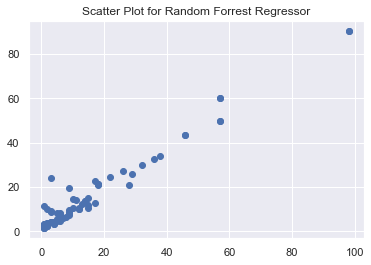

In [40]:

reg = RandomForestRegressor(n_estimators=100)
reg.fit(A, B)

B_predict = reg.predict(A)


rmse = np.sqrt(metrics.mean_squared_error(B, B_predict))
print("\n \nRandom Forest Regression Fit: {:.2f}".format(reg.score(A, B)))
print("\n \nRMSE Of Random Forest Regressor " + str(rmse) )
plt.scatter(B, B_predict)
plt.title("Scatter Plot for Random Forrest Regressor")

#### R-Squared Value of Random Forest Regression is 0.96 (96% accuracy) and RMSE is 3.8 which means the predictor is predicting with an error of 4 medals.

#### Again, Random Forest Regression performs better than Linear Regression

## Comparision of per capita GDP when Japan was the host country vs when Japan wasn't
1. Impact on GDP would vary depending on if the country is a developing country or developed country?
2. Additionally impact would also vary if the country hosts Summer/Winter Olympics

Note : We are not considering the above 2 criterias for our analysis
Result : All the countries show an increase in the GDP/capita over a 3 year period

In [41]:
gdp_pop = gdp_pop.astype({'Year': 'int64'})
gdp_pop.dtypes
host_country_gdp = olympic_host_noc.merge(gdp_pop , left_on = ['Host_Country_code','Year_of_Hosting'] 
                                           , right_on =['Country Code','Year'] , how = 'left' )
host_country_gdp = host_country_gdp.fillna(0)
host_country_gdp = host_country_gdp[host_country_gdp.Year != 0]
host_country_gdp['Per_Capita_GDP'] = host_country_gdp['GDP']/host_country_gdp['Population']

gdp_pop['Per_Capita_GDP'] = gdp_pop['GDP']/gdp_pop['Population']

#Per Capita GDP when Japan was participating
per_capita_gdp_JPN = gdp_pop.loc[gdp_pop['Country Code'] == 'JPN']
print(per_capita_gdp_JPN.head(100))
#Per Capita GDP when Japan was hosting
per_capita_gdp_JPN_host = host_country_gdp.loc[host_country_gdp['Country Code'] == 'JPN']
print(per_capita_gdp_JPN_host.head(10))

     Country Name Country Code  Year           GDP   Population  \
49          Japan          JPN  1960  4.430734e+10   92500572.0   
463         Japan          JPN  1964  8.174901e+10   97826000.0   
917         Japan          JPN  1968  1.466010e+11  101061000.0   
1414        Japan          JPN  1972  3.163930e+11  107188000.0   
1928        Japan          JPN  1976  5.831430e+11  112771000.0   
2471        Japan          JPN  1980  1.099690e+12  116782000.0   
3064        Japan          JPN  1984  1.309740e+12  120018000.0   
3686        Japan          JPN  1988  3.050640e+12  122613000.0   
4377        Japan          JPN  1992  3.897830e+12  124229000.0   
4745        Japan          JPN  1994  4.907040e+12  124961000.0   
5127        Japan          JPN  1996  4.833710e+12  125757000.0   
5515        Japan          JPN  1998  4.032510e+12  126400000.0   
5906        Japan          JPN  2000  4.887520e+12  126843000.0   
6308        Japan          JPN  2002  4.115120e+12  127445000.

In [42]:
nohostyear = per_capita_gdp_JPN['Year']
nohostGDP = per_capita_gdp_JPN['Per_Capita_GDP']
hostyear = per_capita_gdp_JPN_host['Year_of_Hosting']
hostGDP = per_capita_gdp_JPN_host['Per_Capita_GDP']

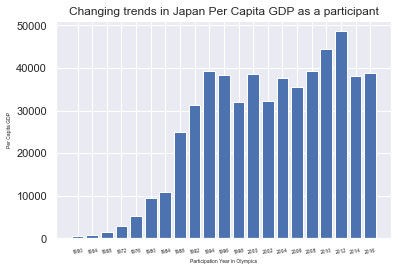

In [43]:
    index = np.arange(len(nohostyear))
    plt.bar(index, nohostGDP)
    plt.xlabel('Participation Year in Olympics', fontsize=5)
    plt.ylabel('Per Capita GDP', fontsize=5)
    plt.xticks(index, nohostyear, fontsize=5,rotation=10)
    plt.title('Changing trends in Japan Per Capita GDP as a participant')
    plt.show()

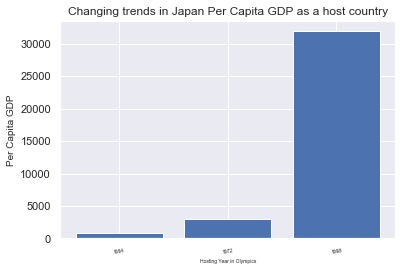

In [44]:
    index = np.arange(len(hostyear))
    plt.bar(index, hostGDP)
    plt.xlabel('Hosting Year in Olympics', fontsize=5)
    plt.ylabel('Per Capita GDP', fontsize=10)
    plt.xticks(index, hostyear, fontsize=5,rotation=10)
    plt.title('Changing trends in Japan Per Capita GDP as a host country')
    plt.show()

### Interesting Stat - 

### How far were the cities that hosted Olympics Each Year from the city that hosted the previous year?

#### (Vectorisation + Numba jit compiler)

##### Ref - https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6

In [45]:
#interesting Stat - 

#how far were the cities that hosted Olympics Each Year?

@jit
def getroutedistance(host_latitude, host_longitude) :
      latitude = list(host_latitude)
      longitude = list(host_longitude)
      distance = []
      distance.append(0)
      for i in range(0,len(latitude)-1):
           # print(latitude[i], longitude[i],latitude[i+1], longitude[i+1])
            source = LatLon(latitude[i], longitude[i])
            destination = LatLon(latitude[i+1], longitude[i+1]) 
            distance.append(m2km(source.distanceTo(destination)))
            #distance.append(m2km(distance))
            #print(distance)
      return distance


olympics_host['distance(KM)'] = getroutedistance(olympics_host['latitude'],olympics_host['longitude'] )

olympics_host

,Host City,Country,Summer (Olympiad),Winter,Year,latitude,longitude,distance(KM)
0,Athens,Greece,I,No_Olympics,1896,37.983333,23.733334,0.000000
1,Paris,France,II,No_Olympics,1900,48.853410,2.348800,2099.511571
2,St. Louis,USA,III,No_Olympics,1904,38.627273,-90.197891,7071.809034
3,London,UK,IV,No_Olympics,1908,51.508415,-0.125533,6777.412442
4,Stockholm,Sweden,V,No_Olympics,1912,59.332577,18.064903,1436.294773
5,Antwerp,Belgium,VII,No_Olympics,1920,51.216667,4.416666,1247.905649
6,Chamonix,France,No_Olympics,I,1924,45.923700,6.869400,615.695252
7,Paris,France,VIII,No_Olympics,1924,48.853410,2.348800,471.639331
8,St. Moritz,Switzerland,No_Olympics,II,1928,46.490800,9.835500,620.202491
9,Amsterdam,Netherlands,IX,No_Olympics,1928,52.307500,4.972222,736.562958


## Analysing Physiological Factors
### Variation of Height and Weight of Olymians Historically

#### Average Height of the Olympians over the years

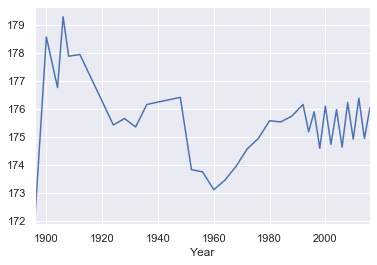

In [46]:
historical = olympics_NOC.dropna(subset=['Height','Weight']).reset_index()
history_height_mean = historical.groupby(['Year'])['Height'].mean()
history_height_mean.plot()

In [47]:
#### Standard Deviation of the Olympians over the years

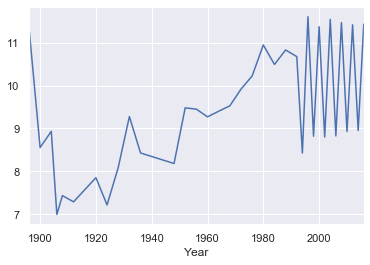

In [48]:
history_height_std = historical.groupby(['Year'])['Height'].std()
history_height_std.plot()

#### Average Weight of the Olympians over the years

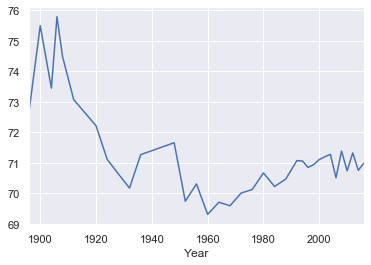

In [49]:
history_weight_mean = historical.groupby(['Year'])['Weight'].mean()
history_weight_mean.plot()


#### Standard Deviation of the Olympians over the years

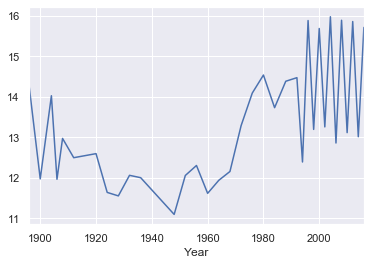

In [50]:
history_weight_std = historical.groupby(['Year'])['Weight'].std()
history_weight_std.plot()


## We Analyse the Claims made by a Research Paper based on 1972 Olympics , when it comes to the Height , Weight and Age of the athletes
#### Research Paper - "Standards on age, height and weight in Olympic running events for men"
#### The paper claims that Medalists in 100m Sprint event are Taller and heavier than other participants.
#### Additionally, we try to explore this claim for Age and BMI as well.
#### Overall Participants Average Height ,Height of the Gold Medalist and Height of All Medalists ( Gold , Silver , Bronze ) of 100m Running Event From 1896 -2016


In [51]:
 sprinter_stats(olympics_NOC , 'Height')

,Year,Overall Participants Average,Gold Medalists,All Medalists
0,1896,176.285714,183.0,173.333333
1,1900,175.714286,167.0,176.000000
2,1904,176.333333,167.0,174.500000
3,1906,177.181818,167.0,171.000000
4,1908,176.500000,170.0,174.000000
5,1912,177.787879,182.0,177.666667
6,1920,178.000000,172.0,175.000000
7,1924,172.615385,183.0,175.333333
8,1928,174.500000,170.0,177.000000
9,1932,175.541667,170.0,176.333333


In [52]:
sprinter_stats(olympics_NOC , 'Height')

,Year,Overall Participants Average,Gold Medalists,All Medalists
0,1896,176.285714,183.0,173.333333
1,1900,175.714286,167.0,176.000000
2,1904,176.333333,167.0,174.500000
3,1906,177.181818,167.0,171.000000
4,1908,176.500000,170.0,174.000000
5,1912,177.787879,182.0,177.666667
6,1920,178.000000,172.0,175.000000
7,1924,172.615385,183.0,175.333333
8,1928,174.500000,170.0,177.000000
9,1932,175.541667,170.0,176.333333


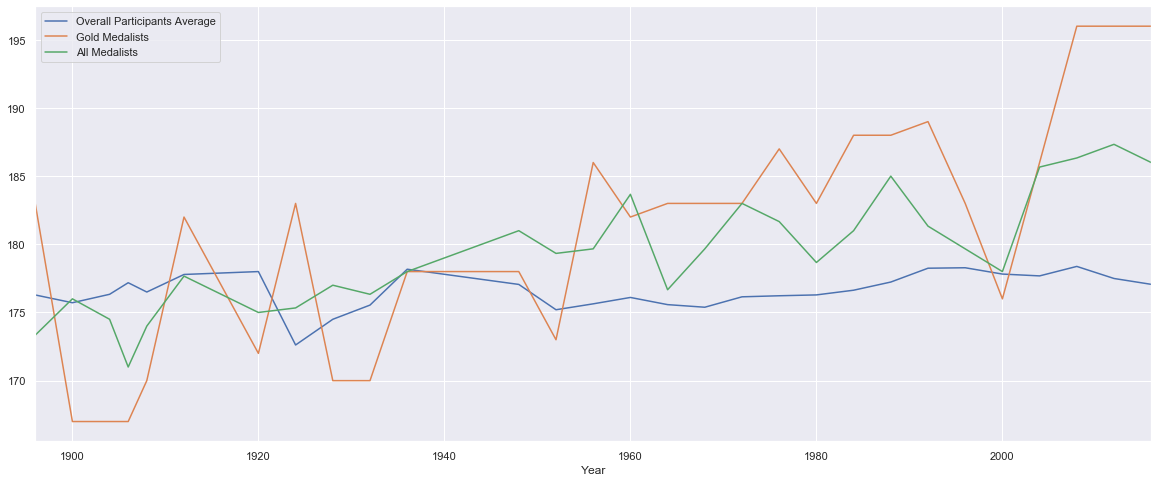

In [53]:
sprinter_stats(olympics_NOC , 'Height').set_index('Year').plot(figsize=(20,8))


In [54]:
sprinter_stats(olympics_NOC , 'Weight')

,Year,Overall Participants Average,Gold Medalists,All Medalists
0,1896,70.857143,66.0,63.666667
1,1900,67.571429,58.0,64.333333
2,1904,68.833333,64.0,67.500000
3,1906,70.090909,64.0,67.000000
4,1908,69.368421,61.0,66.333333
5,1912,69.200000,73.0,70.000000
6,1920,71.076923,75.0,76.000000
7,1924,67.195652,75.0,66.666667
8,1928,67.360000,56.0,71.666667
9,1932,70.117647,65.0,73.333333


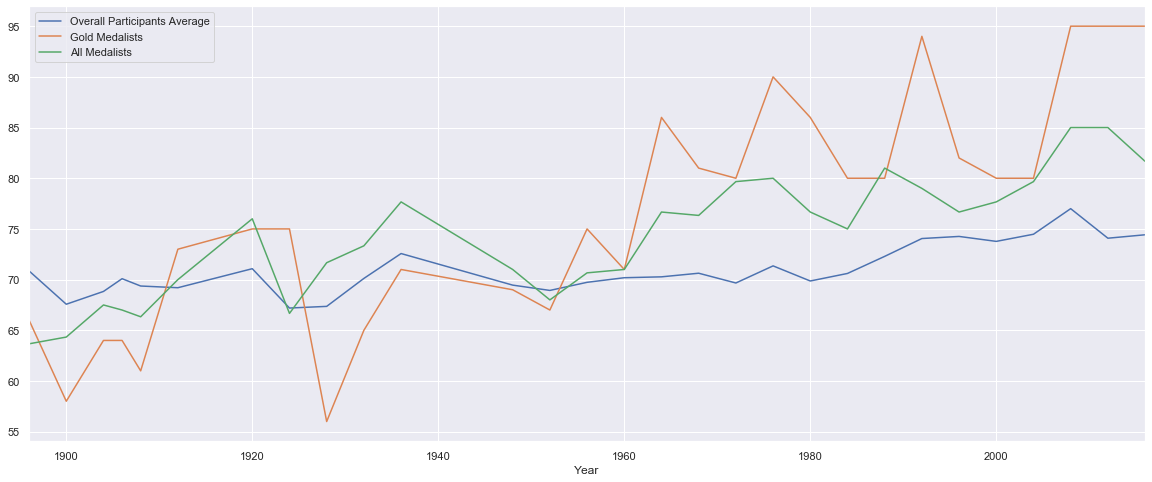

In [55]:
sprinter_stats(olympics_NOC , 'Weight').set_index('Year').plot(figsize=(20,8))

In [56]:
sprinter_stats(olympics_NOC , 'Age')

,Year,Overall Participants Average,Gold Medalists,All Medalists
0,1896,23.000000,21.0,22.500000
1,1900,21.833333,21.0,22.666667
2,1904,22.909091,23.0,21.000000
3,1906,23.928571,25.0,26.000000
4,1908,22.530612,19.0,22.333333
5,1912,22.492754,22.0,21.000000
6,1920,23.036364,19.0,21.666667
7,1924,23.185714,24.0,24.666667
8,1928,22.476923,19.0,21.666667
9,1932,23.074074,23.0,22.333333


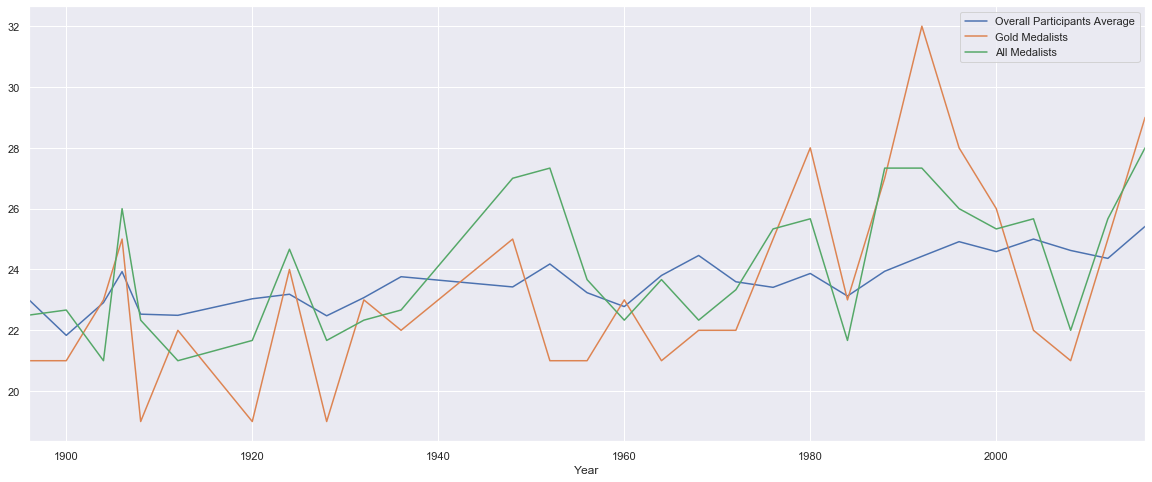

In [57]:
sprinter_stats(olympics_NOC , 'Age').set_index('Year').plot(figsize=(20,8))



### Does history impact olympics? 


#### Comparision of athelete participation over summer and winter olympics
It is known that the participation of athletes varies based on the type of olympics.It can be inferred that summer olympics observes more participation owing to various factors like more participating countries in summer olympics, more events conducted in summer olympics and higher facilities provided for summer olympics

Inspired From -
https://www.kaggle.com/arunsankar/key-insights-from-olympic-history-data






    Year  Athletecount
0   1896           176
1   1900          1220
2   1904           650
3   1906           841
4   1908          2024
5   1912          2409
6   1920          2675
7   1924          3256
8   1928          3246
9   1932          1922
10  1936          4482
11  1948          4402
12  1952          4931
13  1956          3346
14  1960          5348
15  1964          5134
16  1968          5552
17  1972          7105
18  1976          6070
19  1980          5252
20  1984          6791
21  1988          8443
22  1992          9380
23  1996         10324
24  2000         10639
25  2004         10537
26  2008         10880
27  2012         10502
28  2016         11174
    Year  Athletecount
0   1924           313
1   1928           461
2   1932           252
3   1936           668
4   1948           668
5   1952           694
6   1956           821
7   1960           665
8   1964          1094
9   1968          1160
10  1972          1008
11  1976          1127
12  1980   

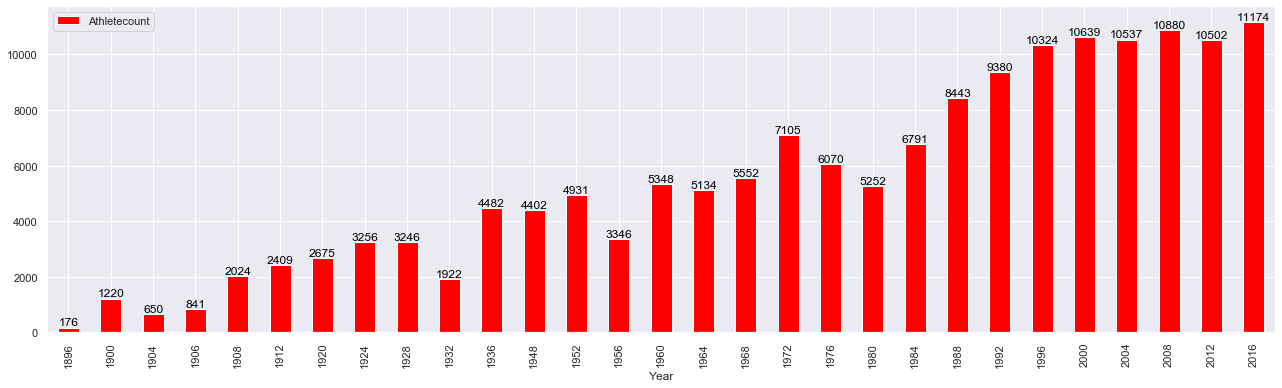

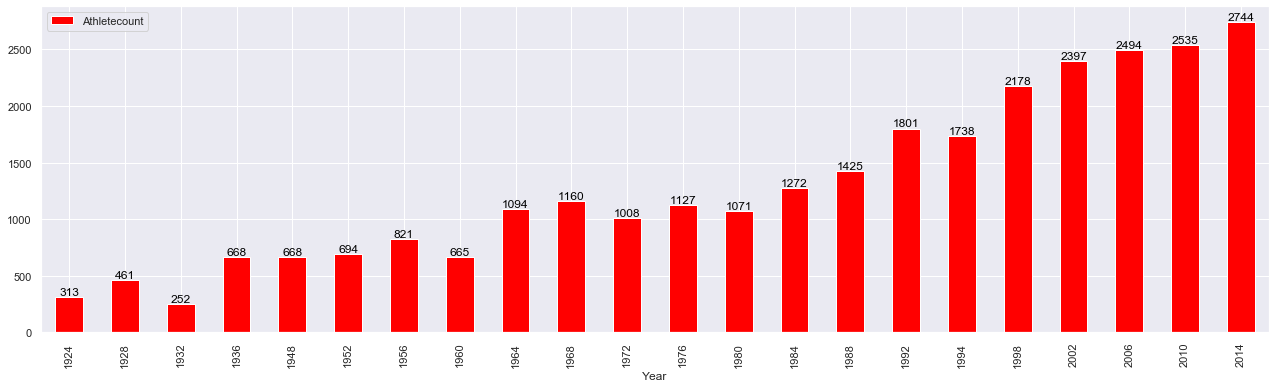

In [58]:
athletes(olympics_NOC, 'Summer')
athletes(olympics_NOC, 'Winter')

##### We can see a noticible dip in participation at 1936 , 1956and 1980  and No Participation during 1940  , 1944
##### On further exploration , we could see that the following Events Led to drastic change in the participation
##### 1936 Summer Olympics (Berlin, Germany) -  Hitler’s rise to power, less countries were invited , Racism .
##### 1940 and 1944 Summer Olympics (not held due to World War II)
##### 1956 Summer Olympics ( Melbourne, Australia) -  Suez Crisis (Egypt, Iraq, and Lebanon ) , Hungarian revolution (Netherlands, Spain, and Switzerland), Republic of China ( Formosa) . 
##### 1980 Summer Olympics (Moscow, Soviet Union) - Soviet invasion of Afghanistan (USA and its allies boycotted)
##### 1984 Summer Olympics (Los Angeles,  United States ) -Russia Boycotted (Security Reasons)





### Comparision of the number of events in Summer and Winter Olympics
It can be observed that summer olympics has more events in comparision to winter olympics.
Summer olympics observes higher number of events because of factors like :
1. It took place before winter olympics started
2. Geographic & infrastructure requirements required for winter olympics

    Year  Eventcount
0   1896          43
1   1900          90
2   1904          95
3   1906          74
4   1908         109
5   1912         107
6   1920         158
7   1924         131
8   1928         122
9   1932         131
10  1936         150
11  1948         153
12  1952         149
13  1956         151
14  1960         150
15  1964         163
16  1968         172
17  1972         193
18  1976         198
19  1980         203
20  1984         221
21  1988         237
22  1992         257
23  1996         271
24  2000         300
25  2004         301
26  2008         302
27  2012         302
28  2016         306
    Year  Eventcount
0   1924          17
1   1928          14
2   1932          14
3   1936          17
4   1948          22
5   1952          22
6   1956          24
7   1960          27
8   1964          34
9   1968          35
10  1972          35
11  1976          37
12  1980          38
13  1984          39
14  1988          46
15  1992          57
16  1994     

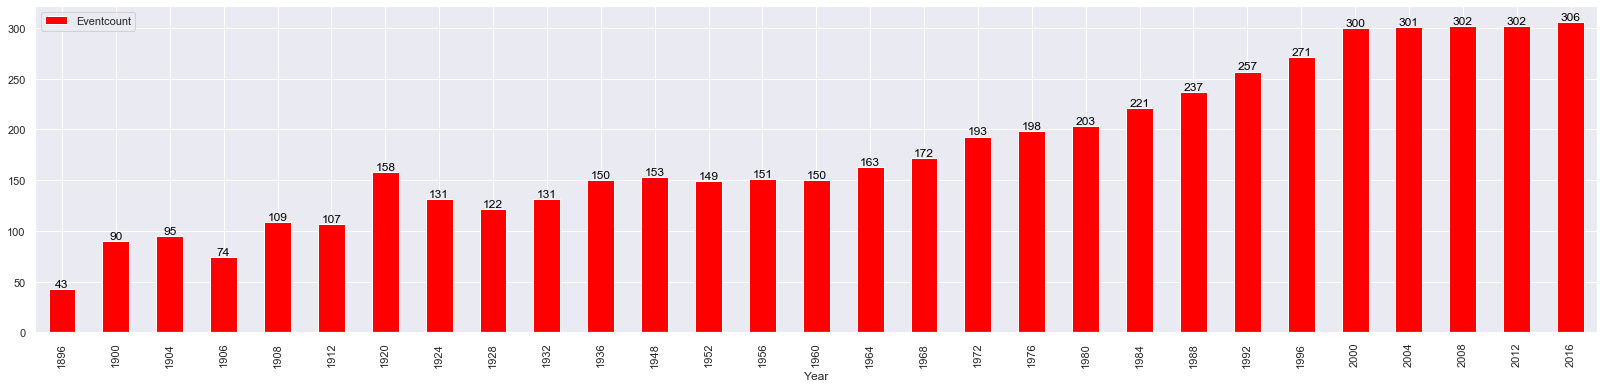

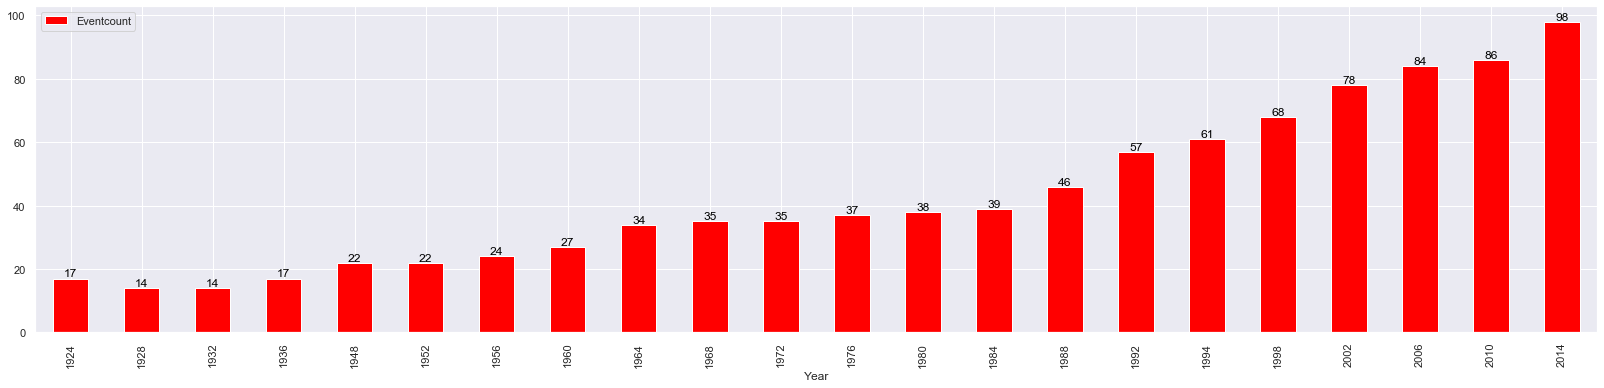

In [59]:
events(olympics_NOC_gdp , 'Summer' )
events(olympics_NOC_gdp , 'Winter' )

### Analyzing female participation trend over the years
It can be observed that female particpation increased tremendously over the years. 
Below are certain factors that contribute towards it:
1. Olympics introduced new women events every year
2. Reputation of Olympics impacted countries to encourage women participation

    Year  Female Trend
0   1900            33
1   1904            16
2   1906            11
3   1908            47
4   1912            87
5   1920           134
6   1924           244
7   1928           404
8   1932           347
9   1936           468
10  1948           628
11  1952          1497
12  1956           893
13  1960          1435
14  1964          1348
15  1968          1777
16  1972          2193
17  1976          2172
18  1980          1756
19  1984          2447
20  1988          3543
21  1992          4124
22  1996          5008
23  2000          5431
24  2004          5546
25  2008          5816
26  2012          5815
27  2016          6223
    Year  Female Trend
0   1924            17
1   1928            33
2   1932            22
3   1936            81
4   1948           133
5   1952           185
6   1956           246
7   1960           295
8   1964           404
9   1968           416
10  1972           415
11  1976           434
12  1980           430
13  1984   

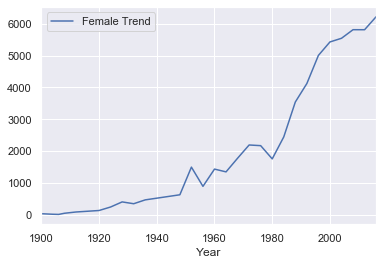

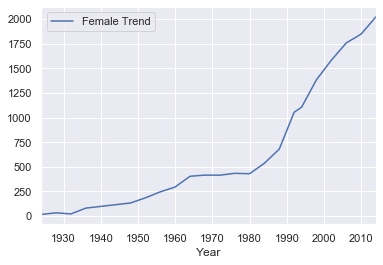

In [60]:
FemaleTrend(olympics_NOC,'F','Summer')
FemaleTrend(olympics_NOC,'F','Winter')

In [61]:
# Deleting the columns where Gold Medal is 0
ZeroGold = olympics_NOC[ olympics_NOC['Gold_Medal'] == 0 ].index
 
# Delete these row indexes
olympics_NOC.drop(ZeroGold , inplace=True)

#### Analyzing top 5 countries who won gold medals over the period in Summer olympics

Inspired From : - https://www.kaggle.com/chadalee/olympics-data-cleaning-exploration-prediction

In [62]:
y = olympics_NOC.groupby(['Season','Sport','region'])['Gold_Medal'].count().reset_index(name="count")
OnlySummer = y[y['Season'] == 'Summer'] 
idx = OnlySummer.groupby(['Sport'])['count'].transform(max) == OnlySummer['count']
OnlySummer[idx].sort_values(by=['count'],ascending=False)
a=OnlySummer[idx].groupby(['region'])['count'].sum().reset_index(name="Summer Gold Medal")
d=a.nlargest(5,'Summer Gold Medal')
d

,region,Summer Gold Medal
17,USA,1846
11,Russia,617
5,Germany,493
8,Italy,221
1,China,136


#### Analyzing top 5 countries who won gold medals over the period in Winter olympics
It can be observed that Nordic countries perform better in Winter olympics than Summer olympics owing to geographic advantage,
better winter events training facilities

In [63]:
OnlyWinter = y[y['Season'] == 'Winter'] 
indx1 = OnlyWinter.groupby(['Sport'])['count'].transform(max) == OnlyWinter['count']
OnlyWinter[indx1].sort_values(by=['count'],ascending=False)
b=OnlyWinter[indx1].groupby(['region'])['count'].sum().reset_index(name="Winter Gold Medal")
c=b.nlargest(5,'Winter Gold Medal')
c

,region,Winter Gold Medal
1,Canada,243
5,Russia,180
2,Germany,109
6,South Korea,45
3,Netherlands,40


#### Calculating top 3 PERFORMING events for USA,RUSSIA AND UK IN SUMMER OLYMPICS 

In [64]:
a1=OnlySummer[idx].groupby(['region','Sport'])['count'].sum().reset_index(name="Summer Gold Medal")
z=a1.groupby(['region','Sport'], sort=False)['Summer Gold Medal'].max().reset_index(name="Summer Count of Gold Medal")

k=z[z['region'] == 'USA']
l=k.nlargest(5,'Summer Count of Gold Medal')
print(l)

k1=z[z['region'] == 'Russia']
l1=k1.nlargest(5,'Summer Count of Gold Medal')
print(l1)

k2=z[z['region'] == 'UK']
l2=k2.nlargest(5,'Summer Count of Gold Medal')
print(l2)


   region       Sport  Summer Count of Gold Medal
53    USA    Swimming                         649
42    USA   Athletics                         542
43    USA  Basketball                         281
51    USA    Shooting                         117
46    USA    Football                          66
    region                  Sport  Summer Count of Gold Medal
21  Russia             Gymnastics                         176
22  Russia               Handball                          97
28  Russia              Wrestling                          97
26  Russia             Volleyball                          93
25  Russia  Synchronized Swimming                          54
   region         Sport  Summer Count of Gold Medal
41     UK    Tug-Of-War                          16
36     UK       Cricket                          12
38     UK          Polo                          11
37     UK  Motorboating                           6
39     UK      Racquets                           3


#### Calculating top 3 PERFORMING events for USA,GERMANY AND NORWAY IN WINTER OLYMPICS

In [65]:
c1=OnlyWinter[indx1].groupby(['region','Sport'])['count'].sum().reset_index(name="Winter Gold Medal")
z=c1.groupby(['region','Sport'], sort=False)['Winter Gold Medal'].max().reset_index(name="Winter Count of Gold Medal")

m=z[z['region'] == 'USA']
n=m.nlargest(5,'Winter Count of Gold Medal')
print(n)

m1=z[z['region'] == 'Germany']
n1=m1.nlargest(5,'Winter Count of Gold Medal')
print(n1)

m2=z[z['region'] == 'Norway']
n2=m2.nlargest(5,'Winter Count of Gold Medal')
print(n2)

   region             Sport  Winter Count of Gold Medal
17    USA      Snowboarding                          10
15    USA  Freestyle Skiing                           8
16    USA          Skeleton                           3
    region        Sport  Winter Count of Gold Medal
4  Germany    Bobsleigh                          48
5  Germany         Luge                          44
6  Germany  Ski Jumping                          17
   region            Sport  Winter Count of Gold Medal
8  Norway  Nordic Combined                          19


## References

### Datasets 

##### Olympics Dataset , NOC -  https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results

##### GDP Dataset -  https://datahub.io/core/gdp

##### Population Dataset - https://vizhub.com/celtic660/datasets/world_pop

##### Human Development Index - https://data.world/brianray/gapminder-hdi-human-developmen

#### Olympics Host - https://www.kaggle.com/pavanraj159/olympic-host



### Books and Research Papers 

##### 1. Jake VanderPlas. 2016. <em>Python Data Science Handbook: Essential Tools for Working with Data</em> (1st ed.). O'Reilly Media, Inc.
##### 2.  McKinney: "Python for Data Analysis", 2nd Edition, by Wes McKinney, ©2017.
##### 3. “Going for Gold Medals: Factors affecting Olympic Performance” -
“https://www.researchgate.net/publication/278585677_Going_for_Gold_Medals_Factors_affecting_Olympic_Performance
##### 4."Standards on age, height and weight in Olympic running events for men" -  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1859632/?page=2

### Online References 

##### 1. https://en.wikipedia.org/wiki/Olympic_Games
##### 2. https://stackoverflow.com/  
##### 3. https://www.olympic.org/
##### 4. https://towardsdatascience.com/understanding-the-need-for-optimization-when-using-pandas-8ce23b83330c
##### 5. https://www.kaggle.com/chadalee/olympics-data-cleaning-exploration-prediction
##### 6. https://www.kaggle.com/pavanraj159/olympics-history-1896-2016
##### 7. https://www.kaggle.com/arunsankar/key-insights-from-olympic-history-data
##### 8. https://en.wikipedia.org/wiki/List_of_Olympic_Games_scandals_and_controversies
